In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/so/Documents/Projects/pyStateEstimator')
from Systems import UniformNonlinearGrowthModel, BearingsOnlyTracking
import sqlite3
from MomentMatching.Estimator import Estimator
from MomentMatching import UnscentedTransform, MonteCarloTransform, TaylorTransform
from ExpectationPropagation.Nodes import build_nodes, node_estimator, node_system
from ExpectationPropagation.Iterations import ep_iterations

In [2]:
def select_transform(id='UT', dim=1, samples=int(1e4)):

    if id.upper() == 'UT':
        transition_transform = UnscentedTransform(dim=dim, beta=2, alpha=1, kappa=3)
        measurement_transform = UnscentedTransform(dim=dim, beta=2, alpha=1, kappa=2)

    elif id.upper() == 'TT':
        transition_transform = TaylorTransform(dim=dim)
        measurement_transform = TaylorTransform(dim=dim)

    elif id.upper() == 'MCT':
        transition_transform = MonteCarloTransform(dim=dim, number_of_samples=samples)
        measurement_transform = MonteCarloTransform(dim=dim, number_of_samples=samples)

    else:
        transition_transform = UnscentedTransform(dim=dim, beta=2, alpha=1, kappa=3)
        measurement_transform = UnscentedTransform(dim=dim, beta=2, alpha=1, kappa=2)

    return transition_transform, measurement_transform

In [27]:
SEED = 7
timesteps = 100
trans_id = 'UT'
system = UniformNonlinearGrowthModel()
np.random.seed(seed=SEED)
data = system.simulate(timesteps)
x_true, x_noisy, y_true, y_noisy = zip(*data)

sys_dim = 1
num_samples = int(1e4)
power, damping = 0.8, 0.8
transform, meas_transform = select_transform(trans_id, dim=sys_dim, samples=int(1e6))
estim = Estimator(trans_map=transform,
                meas_map=meas_transform,
                trans_noise=system.transition_noise.cov,
                meas_noise=system.measurement_noise.cov,
                power=power,
                damping=damping)

In [28]:
con = sqlite3.connect("temp_ungm.db", detect_types=sqlite3.PARSE_DECLTYPES)
cursor = con.cursor()

query_str = "SELECT {}" \
            " FROM {}" \
            " WHERE Transform='{}' AND Seed={} AND Power={} AND Damping={}"

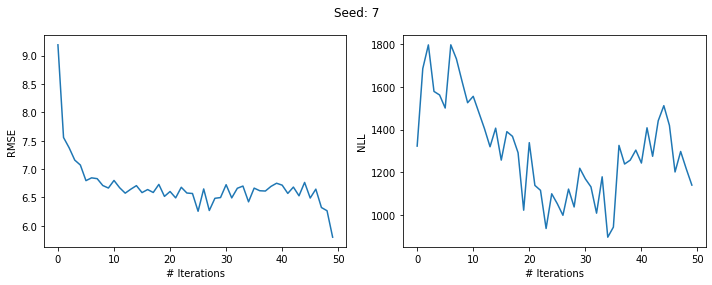

In [29]:
metrics = ['RMSE', 'NLL']
fig, axs = plt.subplots(1, 2, figsize=(10,4))
for i, metric in enumerate(metrics):
    row = cursor.execute(query_str.format(metric, 'UNGM_EXP', trans_id, SEED, 0.8, 0.8)).fetchall()
    axs[i].plot(row)
    axs[i].set_ylabel(metric)
    axs[i].set_xlabel('# Iterations')
plt.suptitle(f'Seed: {SEED}')
plt.tight_layout()

running 1/50
running 2/50
running 3/50
running 4/50
running 5/50
running 6/50
running 7/50
running 8/50
running 9/50
running 10/50
running 11/50
running 12/50
running 13/50
running 14/50
running 15/50
running 16/50
running 17/50
running 18/50
running 19/50
running 20/50
running 21/50
running 22/50
running 23/50
running 24/50
running 25/50
running 26/50
running 27/50
running 28/50
running 29/50
running 30/50
running 31/50
running 32/50
running 33/50
running 34/50
running 35/50
running 36/50
running 37/50
running 38/50
running 39/50
running 40/50
running 41/50
running 42/50
running 43/50
running 44/50
running 45/50
running 46/50
running 47/50
running 48/50
running 49/50
running 50/50


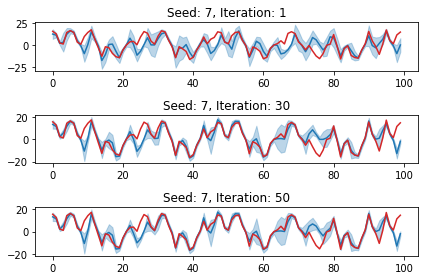

In [30]:
nodes = build_nodes(N=timesteps, dim=sys_dim)
nodes = node_estimator(nodes=nodes, estimator=estim)
nodes = node_system(nodes=nodes, system_model=system, measurements=y_noisy)

max_iter = 50
means = np.zeros((max_iter, timesteps))
stds = np.zeros((max_iter, timesteps))
for i in range(max_iter):
    print(f'running {i+1}/{max_iter}')
    for node in nodes:
        node.fwd_update()
        node.meas_update()
    for node in reversed(nodes):
        node.back_update()
    for j, node in enumerate(nodes):
        means[i, j] = node.marginal.mean
        stds[i, j] = np.sqrt(node.marginal.cov)

iters = [0, 29, 49]
fig, axs = plt.subplots(3)
for i, iter in enumerate(iters):
    m, s = means[iter], stds[iter]
    axs[i].plot(m, 'C0', label='prediction')
    axs[i].fill_between(np.arange(timesteps), m-1.96*s, m+1.96*s, color='C0', alpha=0.3)
    axs[i].plot(x_noisy, 'C3', label='truth')
    #axs[i].legend()
    axs[i].set_title(f'Seed: {SEED}, Iteration: {iter+1}')
plt.tight_layout()